### This notebook generates the moisture-precip relationships for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [4]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [5]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

## Loading ERA-I data

In [26]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -30) & (maxlat_array <= 30) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERAI = negative_to_nan(ctt_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]

-56.0
56.0
(695667,)


In [27]:
# Read in the vertical velocities
omega_array = nc_open_compile(file_years,"omega",'stack')[tropical_indx]
# Extract the value around 500 hPa
omega_ERAI_mid = omega_array[:,14]

# creating cape array from different files and treating for negatives
cape_array = nc_open_compile(file_years,"cape")
cape_ERAI = negative_to_nan(cape_array)[tropical_indx]
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERAI = negative_to_nan(capepre_array)[tropical_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERAI = negative_to_nan(capepre6_array)[tropical_indx]

# Filter for negative values of omega (ascent rates)
omega_ERAI_mid_n, cape_ERAI_n = negative_vals( omega_ERAI_mid, cape_ERAI )
_, capepre6_ERAI_n = negative_vals( omega_ERAI_mid, capepre6_ERAI )
_, rad_ERAI_n = negative_vals( omega_ERAI_mid, rad_ERAI )
_, ctt_ERAI_n = negative_vals( omega_ERAI_mid, ctt_ERAI )
_, minctt_ERAI_n = negative_vals( omega_ERAI_mid, minctt_ERAI )
_, lifetime_ERAI_n = negative_vals( omega_ERAI_mid, lifetime_ERAI )

In [31]:
nbins = 25
pc2 = 99
maxcape = 3500
cape_bins_ascent, ascent_vals, _, ascent_99_vals, _, ascent_error, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n, omega_ERAI_mid_n, pc2=pc2, threshold=20 ) 
capepre6_bins_ascent, ascent_vals2, _, ascent_99_vals2, cape_error_ascent2, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, capepre6_ERAI_n, omega_ERAI_mid_n, pc2=pc2, threshold=20 ) 

# create bins in CAPE and evaluate corresponding ascent rate percentiles for smallest systems
cape_bins_small, ascent_vals_small, _, ascent_99_vals_small, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[rad_ERAI_n <= 110], omega_ERAI_mid_n[rad_ERAI_n <= 110], pc2=pc2, threshold=20 )

# create bins in CAPE and evaluate corresponding ascent rate percentiles for largest systems
cape_bins_large, ascent_vals_large, _, ascent_99_vals_large, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[rad_ERAI_n > 150], omega_ERAI_mid_n[rad_ERAI_n > 150], pc2=pc2, threshold=20 )

# create bins in CAPE and evaluate corresponding ascent rate percentiles for deepest systems
cape_bins_deep, ascent_vals_deep, _, ascent_99_vals_deep, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[minctt_ERAI_n <= 185], omega_ERAI_mid_n[minctt_ERAI_n <= 185], pc2=pc2, threshold=20 )

# create bins in CAPE and evaluate corresponding ascent rate percentiles for shallowest systems
cape_bins_shallow, ascent_vals_shallow, _, ascent_99_vals_shallow, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[minctt_ERAI_n > 205], omega_ERAI_mid_n[minctt_ERAI_n > 205], pc2=pc2, threshold=20 )

# create bins in CAPE and evaluate corresponding ascent rate percentiles for longest lived systems
cape_bins_old, ascent_vals_old, _, ascent_99_vals_old, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[lifetime_ERAI_n > 12], omega_ERAI_mid_n[lifetime_ERAI_n > 12], pc2=pc2, threshold=20 )

# create bins in CAPE and evaluate corresponding ascent rate percentiles for shorteest lived systems
cape_bins_young, ascent_vals_young, _, ascent_99_vals_young, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[lifetime_ERAI_n <= 3], omega_ERAI_mid_n[lifetime_ERAI_n <= 3], pc2=pc2, threshold=20 )

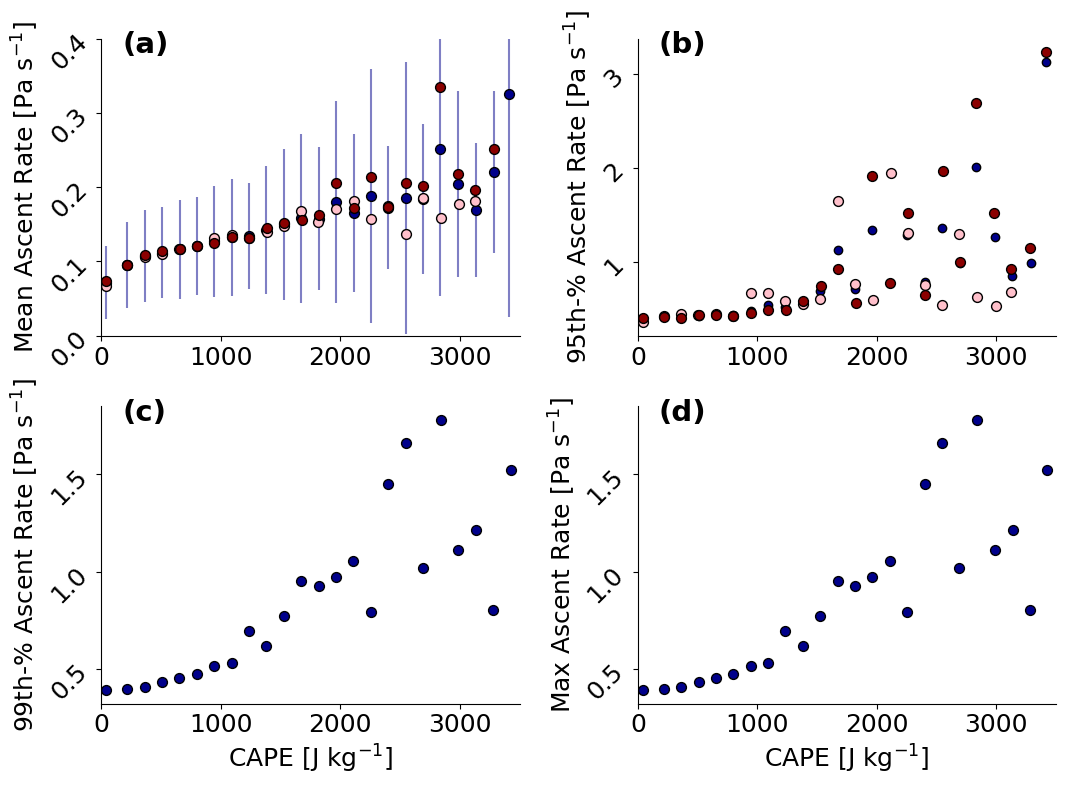

In [32]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 8) )
sz = 50

ylab = [ r'Mean Ascent Rate [Pa s$^{-1}$]', '95th-% Ascent Rate [Pa s$^{-1}$]', r'99th-% Ascent Rate [Pa s$^{-1}$]',\
             r'Max Ascent Rate [Pa s$^{-1}$]' ]
labels = [ '', '' , r'CAPE [J kg$^{-1}$]', 'CAPE [J kg$^{-1}$]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, maxcape] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        axis.scatter( cape_bins_ascent, ascent_vals, s=sz, color = 'darkblue', edgecolor='black' )
        #axis.scatter( cape_bins_small, ascent_vals_small, s=sz, color='gold', edgecolor='black' )
        #axis.scatter( cape_bins_large, ascent_vals_large, s=sz, color='darkorange', edgecolor='black' )
        #axis.scatter( cape_bins_deep, ascent_vals_deep, s=sz, color='turquoise', edgecolor='black' )
        #axis.scatter( cape_bins_shallow, ascent_vals_shallow, s=sz, color='green', edgecolor='black' )
        axis.scatter( cape_bins_old, ascent_vals_old, s=sz, color='pink', edgecolor='black' )
        axis.scatter( cape_bins_young, ascent_vals_young, s=sz, color='darkred', edgecolor='black' )
        axis.errorbar( cape_bins_ascent, ascent_vals, yerr=ascent_error/2, 
                      color = 'darkblue', ls='none', zorder=-1, alpha=0.5 )
        axis.set_ylim([0, 0.4])
    elif i == 1:
        axis.scatter( cape_bins_ascent, ascent_99_vals, color='darkblue', edgecolor='black' )
        #axis.scatter( cape_bins_small, ascent_99_vals_small, s=sz, color='gold', edgecolor='black' )
        #axis.scatter( cape_bins_large, ascent_99_vals_large, s=sz, color='darkorange', edgecolor='black' )
        #axis.scatter( cape_bins_deep, ascent_99_vals_deep, s=sz, color='turquoise', edgecolor='black' )
        #axis.scatter( cape_bins_shallow, ascent_99_vals_shallow, s=sz, color='green', edgecolor='black' )
        axis.scatter( cape_bins_old, ascent_99_vals_old, s=sz, color='pink', edgecolor='black' )
        axis.scatter( cape_bins_young, ascent_99_vals_young, s=sz, color='darkred', edgecolor='black' )
    #    axis.set_ylim([0, 1])
    #elif i == 3:
    #    axis.scatter( cape_max_ascent.flatten(), ascent_max.flatten(), color='blue', edgecolor='black' )
    #    axis.set_ylim([0, 8])
    else:
        axis.scatter( capepre6_bins_ascent, ascent_99_vals2, color='darkblue', s=sz, edgecolor='black')
        #axis.scatter( cape_bins_ascent, ascent_99_vals, color='blue', s=sz, edgecolor='black')
        #axis.scatter( cape_bins_ascent, ascent_99_vals_small, color='gold', s=sz, edgecolor='black')
        #axis.scatter( cape_bins_ascent, ascent_99_vals_large, color='darkorange', s=sz, edgecolor='black')
        #axis.set_ylim([0, 2])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/ascent-CAPE-ERAI.pdf', bbox_inches='tight' )
plt.show() 